In [37]:
from pathlib import Path
from pathlib import *
import pandas as pd
import re
from random import randint
import spacy
from time import time
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
nlpd = spacy.load("da_core_news_lg")
import os

## Topic model over 90'ernes eu-debat

In [38]:
path = "../../Folketingstidende/Hele/"
dir_path = Path(f"{path}")
csv_files = list(dir_path.glob("*.csv"))

In [39]:
csv_files.sort()
csv_files[0:5]

[PosixPath('../../Folketingstidende/Hele/19531.csv'),
 PosixPath('../../Folketingstidende/Hele/19541.csv'),
 PosixPath('../../Folketingstidende/Hele/19551.csv'),
 PosixPath('../../Folketingstidende/Hele/19561.csv'),
 PosixPath('../../Folketingstidende/Hele/19562.csv')]

Jeg finder nu de filer der handler om 90'erne

In [40]:
csv_files[49:61]

[PosixPath('../../Folketingstidende/Hele/19901.csv'),
 PosixPath('../../Folketingstidende/Hele/19902.csv'),
 PosixPath('../../Folketingstidende/Hele/19911.csv'),
 PosixPath('../../Folketingstidende/Hele/19921.csv'),
 PosixPath('../../Folketingstidende/Hele/19931.csv'),
 PosixPath('../../Folketingstidende/Hele/19941.csv'),
 PosixPath('../../Folketingstidende/Hele/19951.csv'),
 PosixPath('../../Folketingstidende/Hele/19961.csv'),
 PosixPath('../../Folketingstidende/Hele/19971.csv'),
 PosixPath('../../Folketingstidende/Hele/19972.csv'),
 PosixPath('../../Folketingstidende/Hele/19981.csv'),
 PosixPath('../../Folketingstidende/Hele/19991.csv')]

In [41]:
Folketingstaler_i_90erne = {}
for fil in csv_files[49:61]:
    if str(fil)[-9:-5] in Folketingstaler_i_90erne:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        for tale in taler:
            Folketingstaler_i_90erne[str(fil)[-9:-5]].append(tale)
    else:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        Folketingstaler_i_90erne[str(fil)[-9:-5]] = []
        for tale in taler:
            Folketingstaler_i_90erne[str(fil)[-9:-5]].append(tale)

In [42]:
def FT_taler(indhold):
    talere = []
    tale = []
    parti = []
    Partier_i_folketinget = ["(A)", "(SF)", "(S)", "(RV)", "(KF)", "(V)", "(FP)", "(CD)", "(VS)",
                             "(KrF)", "(DR)", "(UP)", "(Grønl.)", "(Fær.)", "(DF)", "(EL)"]
    for index in range(len(indhold)):
        sentence = indhold[index]
        if len(re.findall("(^.{1,50} \([A-Z]+\)[ ]*:|^.{1,50} \(KrF\)[ ]*:|^.{1,50} \(Grønl.\)[ ]*:|^.{1,50} \(Fær.\)[ ]*:)", sentence)) > 0: #Tjekker om det er et menigt medlem
            if len(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)) < 2:    
                if len(re.findall("Ny stedf.", sentence)) > 0:
                    pass
                elif len(re.findall("Udtræder:", sentence)) > 0:
                    pass
                elif len(re.findall("Nyt medl", sentence)) > 0:
                    pass
                elif len(re.findall(" af", sentence.lower())) > 0:
                    pass
                elif re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0] in Partier_i_folketinget:
                    if len(sentence) <= 35:
                        talere.append(sentence)
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
                        tale.append("")
                    else: #Tager højde for læsefejl!
                        lang_taler = re.split("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)
                        talere.append(lang_taler[-2])
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", lang_taler[-2])[0])
                        tale.append(lang_taler[-1])
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else: #ellers er det en tale
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
                #if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
        elif len(re.findall("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)) > 0 and re.match("^Af ", sentence):
            talere.append(sentence)
            parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
            tale.append("")
        elif len(re.findall("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence)) > 0:
            if len(sentence) > 35:
                if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
                    if len(re.findall("Ny stedf.", sentence)) > 0:
                        pass
                    elif len(re.findall("Udtræder:", sentence)) > 0:
                        pass
                    elif len(re.findall("Nyt medl", sentence)) > 0:
                        pass
                    elif len(re.findall(" af", sentence.lower())) > 0:
                        pass
                    elif re.findall("(\([A-Z]+\)|\(KrF\))", sentence)[0] in Partier_i_folketinget:
                        problem_menigt = re.split("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence.lower())
                        talere.append(problem_menigt[-2])
                        parti.append("problem")
                        tale.append(problem_menigt[-1])
                    else:
                        if len(tale) >= 1:
                            tale[-1] = tale[-1] + " " + sentence
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif sentence.lower() == "formanden" or sentence.lower() == "formanden:": #tjekker om det er formanden der taler
            talere.append("formanden")
            parti.append("Formanden")
            tale.append("")
        elif re.search("næstformand \(\w*\):$", sentence.lower()) or re.search("næstformand \(\w* \w*\):$", sentence.lower()):
            talere.append(sentence.lower())
            parti.append("næstformanden")
            tale.append("")
        elif len(sentence) < 100: #Tjekker om det er en minister der taler
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\)", sentence.lower())) > 0:
                talere.append(sentence)
                parti.append("Regeringen")
                tale.append("")
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(sentence) >= 100:
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())) > 0:
                tale_med_minister = re.split("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())
                talere.append(tale_med_minister[-2])
                parti.append("Regeringen")
                tale.append(tale_med_minister[-1])
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("[1-9]{1,5} [1-9]{1,2}/[1-9]{1,2}", sentence.lower()))  > 0: #tilføjet til at fange headers på sider
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("^[1-9]{1,2}/[1-9]{1,2}", sentence.lower())) > 0: 
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif re.fullmatch("\[.{1,100}\]", sentence.lower()):
            pass
        elif re.fullmatch("[1-9]{1,10}", sentence.lower()):
            pass
        else:
            if len(tale) >= 1:
                tale[-1] = tale[-1] + " " + sentence
    return tale, talere, parti

In [43]:
Folketingsår_opdelt_per_taler_90erne = {}
problemer = {}
for år in Folketingstaler_i_90erne:
    indhold = Folketingstaler_i_90erne[år]
    år_tale, år_talere, år_parti = FT_taler(indhold)
    Folketingsår_opdelt_per_taler_90erne[år] = []
    Folketingsår_opdelt_per_taler_90erne[år].append(år_tale)
    Folketingsår_opdelt_per_taler_90erne[år].append(år_talere)
    Folketingsår_opdelt_per_taler_90erne[år].append(år_parti)

## Edinburghaftalen i tekst

Jeg undersøger hvordan "Edinburgh" optræder i data. Jeg ønsker at undersøge om byen overhovedet optræder i 1990'ernes folketingsdebatten uden at det handler om edinburghaftalen.

In [44]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
edinburgh_taler = []
edinburgh_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_90erne:
    for sentence in Folketingsår_opdelt_per_taler_90erne[år][0]:
        if len(re.findall("edinburgh", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                edinburgh_taler_ikke_eu.append(sentence.lower())
            else:        
                edinburgh_taler.append((år, sentence.lower()))

In [45]:
len(edinburgh_taler_ikke_eu)

200

In [46]:
ikke_edinburghaftale = []
for sentence in edinburgh_taler_ikke_eu: 
    if len(re.findall("(edinburghaftale|edinburgh-aftale|edinburgh-afgørelse|edinburghafgørelsen)", sentence.lower())) == 0:
        ikke_edinburghaftale.append(sentence)

In [47]:
len(ikke_edinburghaftale)

49

In [48]:
ikke_edinburghaftale[1]

' det interessante ved hele denne debat er den hån, man udviser over for grundloven og det danske folks nej. det er en hån, at man sætter jasigere til at forhandle, det er som at sætte ræven til at vogte gæs. og man fortsætter hånen ved at påstå, at der er kommet nye temaer til. men det er stadig maastrichttraktaten, der bliver genforhandlet eller ikke genforhandlet. det er den samme maastrichttraktat, der er ingen ændringer i den, der er ikke ændret et komma. o.k., der er lavet en aftale på edinburghmødet, men det er stadig væk maastrichttraktaten, det drejer sig om, det er stadig væk afgivelse af suverænitet, og det er stadig en hån mod den danske befolkning. jeg synes, det var interessant at få at vide af de damer og herrer, om vi havde fået en ny afstemning, hvis danmark havde stemt ja. jeg tvivler. det er kun, fordi man absolut vil gennemtvinge et ja, for ellers falder hele den politik, man har lagt op til. mine damer og herrer, det er en hån mod det danske folk! (kort bemærkning)

Jeg renser dem fra der også omhandler maarstrict.

In [49]:
ikke_edinburghaftale_eller_maarstricht = []
for sentence in ikke_edinburghaftale: 
    if len(re.findall("maastricht", sentence.lower())) == 0:
        ikke_edinburghaftale_eller_maarstricht.append(sentence)

In [50]:
len(ikke_edinburghaftale_eller_maarstricht)

28

Jeg kigger nu på dem der hverken indeholder Maarstricht eller Edinburghaftalen.

In [51]:
ikke_edinburghaftale_eller_maarstricht[-1]

' det er lidt ærgerligt, at vi i de debatter, vi har, som jo ellers kunne have været meget, meget spændende og givtige, ofte skal tilbage til historieskrivningen, men det finder jeg nødvendigt igen i forhold til det, fru pernille frahm er inde på. jeg tror, at bare vi kunne få det fælles grundlag, den fælles forståelse, ville det være vigtigt, også af hensyn til den konstruktive del af debatten. i mastrichttraktaten, som var den, danmark tog sine forbehold ud fra, var det allerede forudset, at en række områder kunne flyttes fra søjle 3 til søjle 1. det var det, vi fik vores undtagelse fra, dette søjlespring fra søjle 3 til søjle 1. det var danmark, der fik et forbehold. det var ikke de andre lande. de sagde ikke, at de ville have forbehold fra det, der stod i mastricht- traktaten. vi krævede heller ikke af dem, at de skulle tage et forbehold. vi kom til dem og sagde, at vi gerne ville have et forbehold. det burde sf kunne huske, for sf var jo et af de partier, der var med til at forhan

Fra det ovenstående har jeg en formodning omkring at der snakkes forbehold når edinburgh nævnes, og det altså derfor nødvendigt at sortere disse fra, da der åbenlyst også snakkes EU når der snakkes forbehold.

In [52]:
ikke_edinburghaftale_maarstricht_forbehold = []
for tekst in ikke_edinburghaftale_eller_maarstricht:
    if len(re.findall("forbehold", sentence.lower())) == 0:
        ikke_edinburghaftale_maarstricht_forbehold.append(sentence)
len(ikke_edinburghaftale_maarstricht_forbehold)

0

Det kan da konkluderes at når byen "Edinburgh" nævnes fra folketingets talerstol indgår altid en reference til Edinburghaftalen. Det kan da konkluderes at man fint kan søge på Edinburgh når man søger folketingstaler der omhandler EU.

## Topic model over 1990erne

In [53]:
EU_ord = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarked", "ømu", "maastricht", 
          "amsterdamtraktaten", "eu-", "ef-", "edinburgh", "indre marked"]

In [54]:
eu_taler_90erne = {}
for år in Folketingsår_opdelt_per_taler_90erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_90erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_90erne[år][0][index]
        for ord_ in EU_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_parti_år.append(Folketingsår_opdelt_per_taler_90erne[år][1][index])
                eu_taler_år.append(Folketingsår_opdelt_per_taler_90erne[år][2][index])
                break
    eu_taler_90erne[år] = []
    eu_taler_90erne[år].append(eu_tale_år)
    eu_taler_90erne[år].append(eu_parti_år)
    eu_taler_90erne[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [55]:
Alle_taler = []
Alle_taler_år = []
Alle_taler_parti = []
Alle_taler_taler = []
for år in eu_taler_90erne:
    for index in range(len(eu_taler_90erne[år][0])):
        Alle_taler.append(eu_taler_90erne[år][0][index])
        Alle_taler_parti.append(eu_taler_90erne[år][1][index])
        Alle_taler_taler.append(eu_taler_90erne[år][2][index])
        Alle_taler_år.append(år)

Jeg finder kort ud af hvor mange datapunkter der er tale om.

In [56]:
for år in eu_taler_90erne:
    print(f"{år}: {len(eu_taler_90erne[år][0])}")

1990: 1093
1991: 1646
1992: 1729
1993: 1289
1994: 1699
1995: 2058
1996: 2374
1997: 2049
1998: 1868
1999: 2874


In [80]:
antal_taler_år = [len(eu_taler_90erne[år][0]) for år in eu_taler_90erne]
antal_taler_år

[1093, 1647, 1729, 1290, 1697, 2054, 2365, 2045, 1868, 2870]

Jeg begynder nu at lave en topic model.

In [57]:
nlpd = spacy.load("da_core_news_lg")

In [58]:
tekster_klar = []
fyldetegn = [",", ".", "(", ")", "?", "/", "!", ":", " ", "):", "-", "«", "»", "[", "]"]
stopord_fil = open('../../Folketingstidende/stopord.txt','r')
stopord = [word[:-1] for word in stopord_fil] 
#["forslag", "spørgsmål", "år", "regering", "land", "forslag", "spørgsmål", "år",
#                                                 "lov", "gå", "regering", "sige", "hr.", "mene", "tro", "dag",
#                                                 "tale", "ting", "debat", "stå", "gang", "møde", "folketing", "bruge",
#                                                "forstå", "ske", "række", "sikre", "bruge","bemærkning", "dagsorden", 
#                                                "råd", "svar", "sag", "lovforslag", "foreslå", "fremsætte", "minister",
#                                                "diskussion", "ønske", "spørge", "beslutningsforslag", "redegørelse",
#                                                "give", "nr.", "behandling", "hedde", "måde", "sætte"] 

In [59]:
typer_spacy = []
for tegn in fyldetegn:
    tekst_nlpd = nlpd(tegn)
    for token in tekst_nlpd:
        if token.pos_ not in typer_spacy:
            typer_spacy.append(token.pos_)

In [60]:
typer_spacy.remove("PROPN")

In [61]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'ADJ']

In [62]:
for år in eu_taler_90erne:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_90erne[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar.append(tokens_uden_tegn)
    end = time()
    print(end-start)

159.94299292564392
185.5724220275879
191.82876586914062
155.90270590782166
172.5065040588379
207.61666679382324
243.5491750240326
184.19253587722778
182.9802279472351
220.7036488056183


In [63]:
processed_data = []
for tekst in tekster_klar:
    str_tekst = [str(token) for token in tekst]
    processed_data.append(str_tekst)

In [64]:
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [65]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [66]:
#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

645.9542391300201


In [67]:
stopwords_removed_2 = remove_stopwords(data_lemmatized) #Jeg prøver at sortere stopord fra igen

data_lemmatized = stopwords_removed_2

In [103]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized)

texts = [text for text in data_lemmatized]

In [104]:
from random import shuffle
shuffle(texts)

In [105]:
#building a corpus for the topic model
gensim_dictionary = corpora.Dictionary(texts)

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [106]:
gensim_dictionary.save("Dictionaries/1990_erne/25_10_22")

In [33]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/1990_erne/10_10_22_02")

## Cohenrence model

In [107]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [108]:
min_topics = 18
max_topics = 35
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values(k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


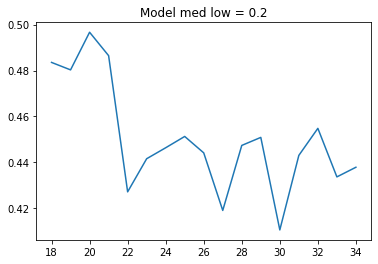

In [109]:
fig, ax = plt.subplots()
ax.plot(model_results["Topics"], model_results['Coherence'])
ax.set_title("Model med low = 0.2")
fig.savefig("plots/1990_erne/Coherence_score_25_10_22")

In [110]:
coherence_best = [coherence for coherence in model_results['Coherence']]
coherence_best.sort(reverse = True)

In [111]:
for top_coherence in coherence_best[0:5]:
    number_topics = model_results["Topics"][model_results['Coherence'].index(top_coherence)]
    print(number_topics)
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=number_topics, random_state=100, 
        update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    lda_model.save(f"Modeller/1990_erne/25_10_2022/Model_{number_topics}_topics")

20
21
18
19
32


In [ ]:
best_number_topics = model_results["Topics"][model_results['Coherence'].index(max(model_results['Coherence']))]
best_number_topics

In [102]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=best_number_topics, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

In [103]:
pprint(lda_model.print_topics(-1))

[(0,
  '0.139*"forslag" + 0.069*"lov" + 0.068*"lovforslag" + 0.044*"ændring" + '
  '0.034*"behandling" + 0.032*"fremsætte" + 0.025*"foreslå" + 0.018*"nr." + '
  '0.018*"udvalg" + 0.014*"folketing"'),
 (1,
  '0.058*"nr." + 0.042*"forespørgsel" + 0.030*"dagsorden" + 0.027*"sf" + '
  '0.024*"v" + 0.022*"kvinde" + 0.021*"afstemning" + 0.020*"folketing" + '
  '0.020*"elisabeth_arnold" + 0.020*"charlotte_antonsen"'),
 (2,
  '0.483*"hr." + 0.039*"keld_albrechtsen" + 0.038*"bemærkning" + '
  '0.033*"nielsen" + 0.021*"ove_fich" + 0.021*"holger_k" + 0.017*"indtægt" + '
  '0.016*"indlæg" + 0.016*"spørge" + 0.011*"frank_dahlgaard"'),
 (3,
  '0.111*"bil" + 0.099*"færøerne" + 0.051*"bank" + 0.048*"trafik" + '
  '0.030*"finanstilsyn" + 0.028*"landsstyre" + 0.021*"køre" + 0.016*"benzin" + '
  '0.013*"ef-regi" + 0.010*"vægtafgift"'),
 (4,
  '0.046*"marked" + 0.043*"landbrug" + 0.042*"produkt" + 0.041*"afgift" + '
  '0.032*"forbruger" + 0.026*"vare" + 0.024*"virksomhed" + 0.023*"landmand" + '
  '0.022*"

In [43]:
#temp_file = datapath("LDA_1990_topics_27_09_22_med_adv")
#lda_model.save(f"Speciale_scripts/Modeller/1990_erne/04_10_22/Model_")

### Undersøgelse af topic models:

In [40]:
def topic_counter(data_lemmatized, topic_number):
    topics_subject = []
    topics_subject_sand = []
    for index in range(len(data_lemmatized)):
        bow = gensim_dictionary.doc2bow(data_lemmatized[index])
        eu_tale_topic_distribution = lda_model.get_document_topics(bow)
        for topic, sand in eu_tale_topic_distribution:
            if topic == topic_number:
                topics_subject.append(index)
                topics_subject_sand.append(sand)
    return topics_subject, topics_subject_sand

In [41]:
def year_counter(topics_subject):
    year_datapoints = [Alle_taler_år[i] for i in topics_subject]
    year_numbers = []
    for år in år_1990erne:
        year_numbers.append(year_datapoints.count(år))
    return year_numbers

In [42]:
år_1990erne = [str(1990+i) for i in range(10)]
år_1990erne

['1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999']

In [43]:
folketingsår = [str(90 + i) + "/" + str(90 + i + 1) for i in range(9)] + ["99/00"]
folketingsår

['90/91',
 '91/92',
 '92/93',
 '93/94',
 '94/95',
 '95/96',
 '96/97',
 '97/98',
 '98/99',
 '99/00']

In [116]:
lda_model = gensim.models.ldamodel.LdaModel.load("Modeller/2000_erne/25_10_2022/Model_20_topics")
pprint(lda_model.print_topics(-1))

FileNotFoundError: [Errno 2] No such file or directory: 'Modeller/2000_erne/25_10_2022/Model_20_topics'

10_10_2022_02/Model_30_topics bruges i opgaven.

### Undersøgelse af topic 8

In [70]:
topics_union = []
topics_union_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 0:
            topics_union.append(index)
            topics_union_sand.append(sand)
len(topics_union)

2742

In [71]:
topics_union_år = [Alle_taler_år[i] for i in topics_union]
topics_union_antal_taler_1980eren = []

for år in år_1990erne:
    topics_union_antal_taler_1980eren.append(topics_union_år.count(år))
topics_union_andel = [topics_union_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

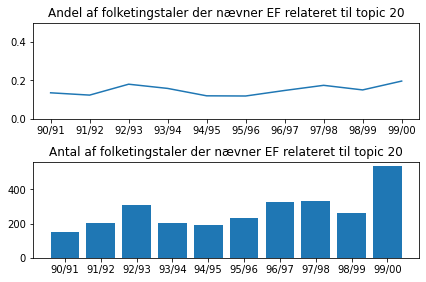

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 20")
ax1.plot(folketingsår, topics_union_andel)
ax1.set_ylim([0, 0.5])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 20")
ax2.bar(folketingsår, topics_union_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_20")

### Undersøgelse af topics

In [73]:
colors = ["b", "g", "r", "c", "m", "y", "k"]

(0.0, 1.0)

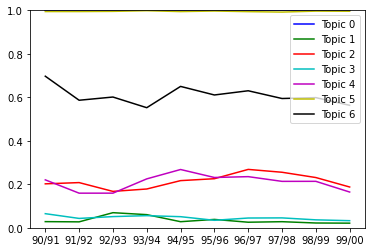

In [153]:
fig, ax = plt.subplots()
for topic_number in range(7):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(10)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number])
ax.legend()
ax.set_ylim([0, 1])

(0.0, 1.0)

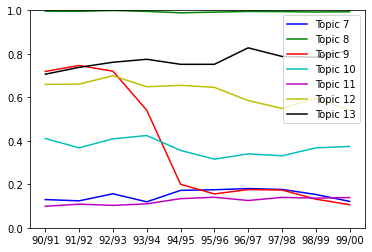

In [154]:
fig, ax = plt.subplots()
for topic_number in range(7,14):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(10)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1])

(0.0, 1.0)

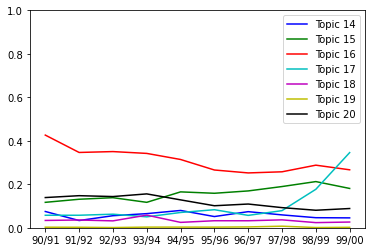

In [206]:
fig, ax = plt.subplots()
for topic_number in range(14,21):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(10)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1])

(0.0, 1.0)

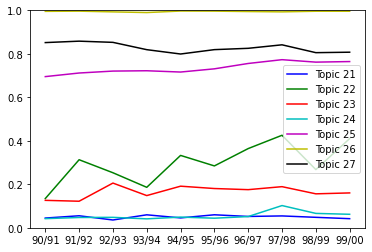

In [156]:
fig, ax = plt.subplots()
for topic_number in range(21,28):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(10)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1])

(0.0, 1.0)

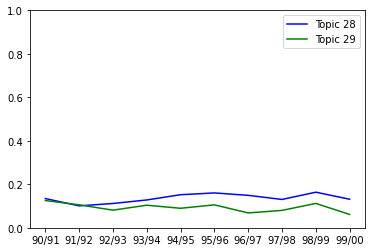

In [157]:
fig, ax = plt.subplots()
for topic_number in range(28,30):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(10)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1])

# Undersøgelse af topics:

### Topic 1:

In [176]:
topics_1 = []
topics_1_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 1:
            topics_1.append(index)
            topics_1_sand.append(sand)
len(topics_1)

601

In [171]:
topics_1_år = [Alle_taler_år[i] for i in topics_1]
topics_1_antal_taler_1980eren = []

for år in år_1990erne:
    topics_1_antal_taler_1980eren.append(topics_1_år.count(år))
topics_1_andel = [topics_1_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

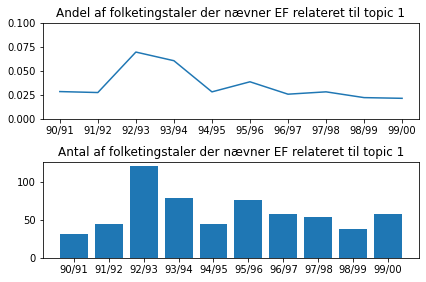

In [172]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 1")
ax1.plot(folketingsår, topics_1_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 1")
ax2.bar(folketingsår, topics_1_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_20")

In [173]:
topics_1_sand.index(max(topics_1_sand))

73

In [174]:
topics_1[73]

2660

In [175]:
Alle_taler[2660]

' Jeg kan svare hr. Ole Donner, at den udtalelse, jeg kom med under andenbehandlingen, er fuldstændig i overensstemmelse med realiteterne omkring dette forslag. Det, hr. Ole Donner nu rejser, er spørgsmålet, om det ændringsforslag, der nu skal til afstemning, er i overensstemmelse med EF-ret- ten, og dér er det korrekt, som hr. Ole Donner refererer, at man ikke på forhånd kan udelukke, at der kan være et problem, men som hr. Ole Donner også vil vide fra det pågældende notat, er det vurderingen, at det næppe er sandsynligt, at EF vil gøre indsigelse mod forslaget. Beskatningen af fremmedmøntede fordringer vil nemlig fortsat generelt være symmetrisk. Det er kun på dette ene lille begrænse- 11085 19/6 92: 3. beh. af f. t. 1. vedr. koncerninterne fordringer m.v. 11086 [Skatteministeren] de område, at hr. Stavad og andre nu vil bryde symmetrien. Derfor har jeg ingen intentioner om at rejse dette spørgsmål i forhold til EF- myndighederne. Endvidere skal jeg afslutningsvis - for det bliver så

### Topic 18

In [178]:
topics_18 = []
topics_18_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 18:
            topics_18.append(index)
            topics_18_sand.append(sand)
len(topics_18)

585

In [180]:
topics_18_år = [Alle_taler_år[i] for i in topics_18]
topics_18_antal_taler_1980eren = []

for år in år_1990erne:
    topics_18_antal_taler_1980eren.append(topics_18_år.count(år))
topics_18_andel = [topics_18_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

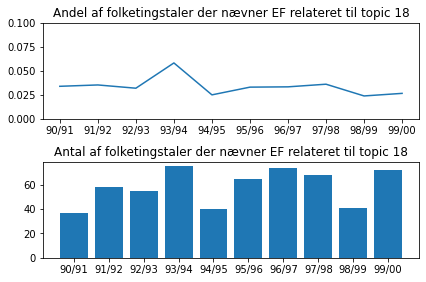

In [181]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 18")
ax1.plot(folketingsår, topics_18_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 18")
ax2.bar(folketingsår, topics_18_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_20")

In [191]:
sand_18 = [sand for sand in topics_18_sand]
sand_18.sort(reverse = True)

In [203]:
best_sand = topics_18_sand.index(sand_18[2])

In [204]:
best_sand_tale = topics_18[best_sand]

In [205]:
print(Alle_taler_år[best_sand_tale])
Alle_taler[best_sand_tale]

1993


" Der henvises til medfølgende oversigt. Kulturministerens rejser Destination: Bruxelles. Dato: 4.-6. februar 1993. Formål: Åbning af »Danish Visions«-udstil- lingen i Europa-Kommissionen og Rådssekre- tariatet. Møder med kommissær Pinheiro og generaldirektør Colette Flesch. Ledsagere: Departementschef Erik Jacobsen, kontorchef Lasse Lindhard, fuldmægtig Eva Zierau. Pris: Kr. 34.735,14. Destination: Oslo. Dato: 1.-4. marts 1993. Formål: Nordisk Råds 42. session, møde med den norske kulturminister og fællesnordisk kulturministermøde. Ledsagere: Departementschef Erik Jacobsen, kt.chef Lasse Lindhard, ministersekretær Preben Svendsen. Pris: Kr. 30.262,35. Destination: Bruxelles. Dato: 23. marts 1993. Formål: Besøg i Europa-Parlamentet i egenskab af formand for kulturministrene forsamlet i Rådet for De Europæiske Fællesskaber. Tale for Europarådets medlemmer med efterfølgende spørgsmål/svarrunde. Ledsagere: Ingen. Pris: Kr. 6.498,45. Destination: Antwerpen. Dato: 26.-27. marts 1993. Formål

### Topic 19

In [207]:
topics_19 = []
topics_19_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 19:
            topics_19.append(index)
            topics_19_sand.append(sand)
len(topics_19)

55

In [208]:
topics_19_år = [Alle_taler_år[i] for i in topics_19]
topics_19_antal_taler_1980eren = []

for år in år_1990erne:
    topics_19_antal_taler_1980eren.append(topics_19_år.count(år))
topics_19_andel = [topics_19_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

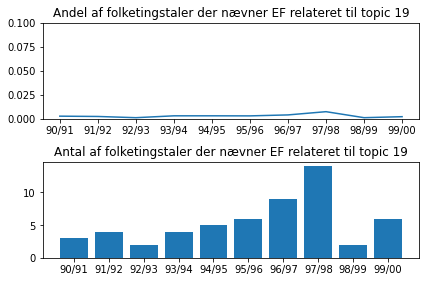

In [209]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 19")
ax1.plot(folketingsår, topics_19_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 19")
ax2.bar(folketingsår, topics_19_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_20")

In [213]:
sand_19 = [sand for sand in topics_19_sand]
sand_19.sort(reverse = True)

In [218]:
best_sand = topics_19_sand.index(sand_19[1])
best_sand_tale = topics_19[best_sand]
print(Alle_taler_år[best_sand_tale])
Alle_taler[best_sand_tale]

1997


' Det er selvfølgelig interessant, at Enhedslisten nu er gået i kraftigt forsvar for de undtagelser, som man tidligere har påstået ikke var noget som helst. Men jeg er helt med på, at vi står skulder ved skulder i forsvaret for undtagelserne på disse vigtige områder, som jo netop er områder, der fører frem til en egehtlig unionsudvikling. Her er det helt, helt afgørende, at vi også fortsat står uden for. Jeg synes, det er et problem, også når man hører regeringens argumentation, at man argumenterer udelukkende juridisk. Som jeg har sagt tidligere i dag, har det været utrolig vigtigt for os, at der bliver substans i det her, og at det bliver et udtryk for en ny og langsigtet dansk Europapolitik. Derfor nytter det ikke noget at påstå, at man har nogle juridiske formuleringer stående på et papir, hvis man i substansen, i indholdet, i realiteten ikke lever op til undtagelserne. Her har vi problemerne med Schengenaftalen. Jeg har tidligere i dag gjort rede for, at her er den retlige undtage

### Topic 19 og 21

In [251]:
topics_ømu = []
topics_ømu_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 17:
            topics_ømu.append(index)
            topics_ømu_sand.append(sand)
len(topics_ømu)

2128

In [253]:
topics_folkeafstemning = []
topics_folkeafstemning_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 22:
            topics_folkeafstemning.append(index)
            topics_folkeafstemning_sand.append(sand)
len(topics_folkeafstemning)

5624

In [254]:
topics_ømu_år = [Alle_taler_år[i] for i in topics_ømu]
topics_ømu_antal_taler_1980eren = []

for år in år_1990erne:
    topics_ømu_antal_taler_1980eren.append(topics_ømu_år.count(år))
topics_ømu_andel = [topics_ømu_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

In [255]:
topics_folkeafstemning_år = [Alle_taler_år[i] for i in topics_folkeafstemning]
topics_folkeafstemning_antal_taler_1980eren = []

for år in år_1990erne:
    topics_folkeafstemning_antal_taler_1980eren.append(topics_folkeafstemning_år.count(år))
topics_folkeafstemning_andel = [topics_folkeafstemning_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

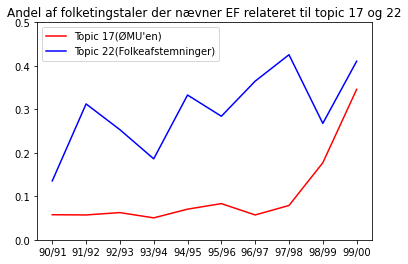

In [258]:
fig, ax1 = plt.subplots()
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 17 og 22")
ax1.plot(folketingsår, topics_ømu_andel, color = "r", label= "Topic 17(ØMU'en)")
ax1.plot(folketingsår, topics_folkeafstemning_andel, color = "b", label= "Topic 22(Folkeafstemninger)")
ax1.set_ylim([0, 0.5])
ax1.legend()
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EU_EF_relateret_til_topic_17_22")

1994/1995?

In [231]:
taler_1994 = [i for i in topics_folkeafstemning if Alle_taler_år[i] == "1994"]
taler_1994_sand = [topics_folkeafstemning_sand[topics_folkeafstemning.index(i)] for i in topics_folkeafstemning if Alle_taler_år[i] == "1994"]
len(taler_1994)

534

In [233]:
sand_1994_f = [sand for sand in taler_1994_sand]
sand_1994_f.sort(reverse = True)

In [243]:
best_sand = sand_1994_f.index(sand_1994_f[8])
best_sand_tale = taler_1994[best_sand]
print(Alle_taler_år[best_sand_tale])
Alle_taler[best_sand_tale]

1994


' Fru Jette Gottlieb viser sig at være særdeles velbevandret i Venstres politik. Det skal jeg anerkende, og jeg skal gerne fastslå, at det er Venstres klare og helt ufravigelige forudsætning, at der overhovedet ikke kommer skattekroner i Øresundsprojektet. Det er en forudsætning, som vi har forstået regeringen står bag, og som jeg forstår også økonomiministeren står bag, og som økonomiministeren er ansvarlig for, og det kan vi helt holde os til. Så skal jeg sige til hr. Torben Lund: Venstre har overhovedet ikke foreslået større tilskud til erhvervslivet, tværtimod lavere tilskud, men til gengæld også lavere omkostninger. Det kan hr. Torben Lund alt sammen orientere sig om ved at læse det oplæg fra Venstre og De Konservative, som hedder »På ret kurs igen«. Og så en bemærkning til hr. Ove Fich, som syntes, at det var en underlig måde at skabe offentlig og bred debat om den europæiske udvikling på sådan at starte med at komme med nogle synspunkter. Jamen jeg må stille mig selv det spørgsm

### Miljø topic 4

In [259]:
topics_miljø = []
topics_miljø_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 4:
            topics_miljø.append(index)
            topics_miljø_sand.append(sand)
len(topics_miljø)

3697

In [260]:
topics_miljø_år = [Alle_taler_år[i] for i in topics_miljø]
topics_miljø_antal_taler_1980eren = []

for år in år_1990erne:
    topics_miljø_antal_taler_1980eren.append(topics_miljø_år.count(år))
topics_miljø_andel = [topics_miljø_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

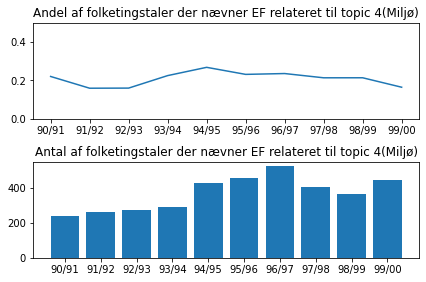

In [269]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 4(Miljø)")
ax1.plot(folketingsår, topics_miljø_andel)
ax1.set_ylim([0, 0.5])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 4(Miljø)")
ax2.bar(folketingsår, topics_miljø_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_20")

In [48]:
sand_miljø = [sand for sand in topics_miljø_sand]
sand_miljø.sort(reverse = True)

In [232]:
best_sand = sand_miljø.index(sand_miljø[4])
best_sand_tale = topics_miljø[best_sand]
print(Alle_taler_år[best_sand_tale])
Alle_taler[best_sand_tale]

1990


" Først vil jeg gerne takke SF for forespørgslen. Det er en god anledning til at drøfte et af de væsentligste internationale miljøspørgsmål, måske det væsentligste. Jeg vil også meget gerne takke ordføreren, fru Margrete Auken, for en flot og personlig kronik i Politiken i dag, hvor fru Margrete Auken kommer ind på nødvendigheden af, at vi begynder at tale sammen på en anden facon. Det håber jeg også denne debat vil kunne give anledning til, for jeg er enig med fru Margrete Auken i, at det er meget væsentligt. For mig er ophobningen af kuldioxid i Jordens atmosfære og den deraf følgende drivhuseffekt et miljøproblem af enorme, nærmest uoverskuelige, dimensioner. Det er samtidig en udfordring, som vi er nødt til at forholde os til. Stiger temperaturen, forandres betingelserne for vores civilisation. Med »vi« og med »os« mener jeg det internationale samfund og hermed Danmark og Folketinget som en del af det internationale samfund. Drivhuseffekten er et globalt anliggende, og svarene skal

In [54]:
topic_4_om_miljø = []
for i in topics_miljø:
    if "miljø" in data_lemmatized[i] or "miljøminister" in data_lemmatized[i]:
        topic_4_om_miljø.append(i)
len(topic_4_om_miljø)

1097

In [55]:
n = 0
for i in range(len(data_lemmatized)):
    

2139

### Topic 14 om landbrug:

In [263]:
topics_landbrug = []
topics_landbrug_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 14:
            topics_landbrug.append(index)
            topics_landbrug_sand.append(sand)
len(topics_landbrug)

1027

In [264]:
topics_landbrug_år = [Alle_taler_år[i] for i in topics_landbrug]
topics_landbrug_antal_taler_1980eren = []

for år in år_1990erne:
    topics_landbrug_antal_taler_1980eren.append(topics_landbrug_år.count(år))
topics_landbrug_andel = [topics_landbrug_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

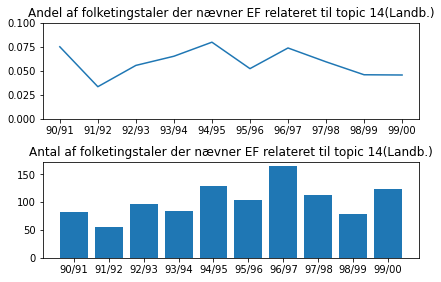

In [278]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 14(Landb.)")
ax1.plot(folketingsår, topics_landbrug_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 14(Landb.)")
ax2.bar(folketingsår, topics_landbrug_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_14")

### Landbrug 1997/1998:

In [280]:
landbrug_1996 = [i for i in topics_landbrug if Alle_taler_år[i] == "1996"]
landbrug_1996_sand = [sand for sand in topics_landbrug_sand if Alle_taler_år[topics_landbrug[topics_landbrug_sand.index(sand)]] == "1996"]

In [283]:
best_sand = landbrug_1996_sand.index(landbrug_1996_sand[2])
best_sand_tale = landbrug_1996[best_sand]
print(Alle_taler_år[best_sand_tale])
Alle_taler[best_sand_tale]

1996


" Ud over den noget amerikaniserede form og det signal til befolkningen, som lå i åbningstalen, var den fyldt med ganske megen ordflom. Det kan naturligvis skyldes statsministerens ulyst til at formulere sig i klare vendinger, men set fra Enhedslistens synspunkt var der ikke noget nyt under solen. At vi opfatter talen på den måde, skyldes muligvis vores grundlæggende position i det her parlament, i det her Folketing. Regeringen har fyldt de sidste års åbningstaler og lovkataloger med nedskæringer og stramninger over for unge og arbejdsløse. Knap var blækket tørt og de sidste overgangsbestemmelser gennemløbet, før udhuling og indskrænkninger var på dagsordenen igen. I lyset af det forløb er det naturligvis en lettelse, at regeringen nu har dekreteret reformpause på området. Det forekommer bare meningsløst, at en såkaldt reformpause ser ud til at skulle gælde hele arbejdsmarkedsområdet. Når det drejer sig om, at det er nødvendigt med en indsats, der skal gøre arbejde til menneskelig virk

### Topic 3 Grønland:

In [284]:
topics_grønland = []
topics_grønland_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 3:
            topics_grønland.append(index)
            topics_grønland_sand.append(sand)
len(topics_grønland)

791

In [285]:
topics_grønland_år = [Alle_taler_år[i] for i in topics_grønland]
topics_grønland_antal_taler_1980eren = []

for år in år_1990erne:
    topics_grønland_antal_taler_1980eren.append(topics_grønland_år.count(år))
topics_grønland_andel = [topics_grønland_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

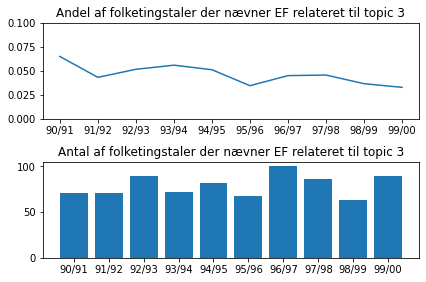

In [287]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 3")
ax1.plot(folketingsår, topics_grønland_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 3")
ax2.bar(folketingsår, topics_grønland_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("Speciale_scripts/plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_3")

In [292]:
for index in range(len(data_lemmatized)):
    tekst = data_lemmatized[index]
    if "færøerne" in tekst or "grønland" in tekst:
        if "idræt" in tekst:
            print(index)

3325
12657


In [234]:
Alle_taler[3325]

" Det danske samfund er i grunden et godt samfund for de fleste, faktisk et af de bedste i verden. Det mener vi selv i Danmark, det anerkender de fleste ude omkring, og det bekræfter internationale sammenligninger. De fleste mennesker i Danmark har. fortsat et godt grundlag for et trygt udviklende liv med mange muligheder, men ser vi blot lige neden under overfladen, er det ikke tiden for skønmaleri af vor situation, for det er samtidig et samfund i arbejdsløshed, i utryghed for mange, der føler sig udenfor, i usikkerhed hos mange, der har arbejde, over for, hvorvidt de nu kan bevare jobbet. Hvordan sikrer vi fortsat vor velfærd, sociale tryghed, uddannelse og jobmuligheder for de unge og tryghed i alderdommen? Det er en ny tid og en forandringens tid, som både skaber usikkerhed og helt nye muligheder for os alle. Verden omkring os har på få år forandret sig dramatisk på både godt og ondt. Kold krig er afløst af borgerkrige og uro, men også af nye muligheder for en fredeligere udviklin

In [235]:
Alle_taler_år[3325]

'1992'

### Topic 15 om menneskerettigheder og topic 24 om flygtninge:

In [279]:
topics_menneskerettigheder = []
topics_menneskerettigheder_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 15:
            topics_menneskerettigheder.append(index)
            topics_menneskerettigheder_sand.append(sand)
len(topics_menneskerettigheder)

2906

In [63]:
topics_menneskerettigheder_år = [Alle_taler_år[i] for i in topics_menneskerettigheder]
topics_menneskerettigheder_antal_taler_1990eren = []

for år in år_1990erne:
    topics_menneskerettigheder_antal_taler_1990eren.append(topics_menneskerettigheder_år.count(år))
topics_menneskerettigheder_andel = [topics_menneskerettigheder_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

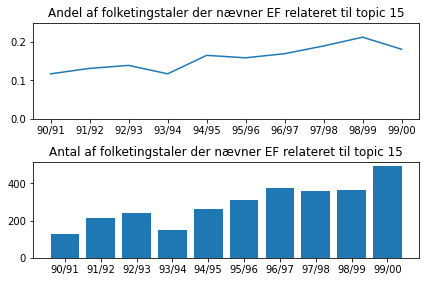

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 15")
ax1.plot(folketingsår, topics_menneskerettigheder_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 15")
ax2.bar(folketingsår, topics_menneskerettigheder_antal_taler_1990eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_15")

In [71]:
topic_15_tyrkiet = []
for i in topics_menneskerettigheder:
    if "tyrkiet" in data_lemmatized[i]:
        topic_15_tyrkiet.append(i)
len(topic_15_tyrkiet)

152

In [77]:
Alle_taler[topic_15_tyrkiet[6]]

' Når hr. Pelle Voigt siger: Kan vi ikke give våbenhjælp til kurderne? - og i øvrigt i den forbindelse nævner nogle våben, vi mig bekendt ikke må have i Danmark, bl.a. fordi hr. Pelle Voigt har forhindret det - og når hr. Ole Espersen siger, lidt mere elegant, end jeg nu udtrykker det, men det var vist meningen: Kan vi ikke blæse lidt på de internationale regler? Det, der foregår, er jo så alvorligt, at vi må sætte militær magt ind. Så må jeg sige ærligt og redeligt, at det er synspunkter, jeg udmærket forstår, og at jeg følelsesmæssigt selv kunne gå med et langt stykke af vejen. Men jeg gør bare stilfærdigt opmærksom på, at vi derved bringer os selv i et moralsk dilemma, for her drejer det altså om nogle mennesker, hvis skæbne påkalder sig vores sympati, og som er så rimelig tæt på, også på grund af medierne, at vi kan følge med i, hvad der sker. Men hvad næste gang, hvor spørgsmålet måske er lidt mindre klart? Vil vi så også være rede til at sige: Jamen her må man sende våben hen, he

In [93]:
Alle_taler[6970]

' Da mit partis ordfører, hr. Per Stig Møller, ikke kan være til stede, skal jeg på hans vegne kommentere forslaget. Indledningsvis vil jeg gerne give udtryk for, at vi fra konservativ side selvfølgelig finder det aldeles uacceptabelt, at Tyrkiet krænker folkeretten ved at gå ind i Nordirak. Tilsvarende finder vi det uacceptabelt, at Tyrkiet krænker menneskerettighederne i en vidtgående kamp mod kurderne. Lad mig i den forbindelse nævne, at der er millioner af tyrkere, for hvem kurdisk er deres modersmål, og at Tyrkiet derfor må være indstillet på, at disse mange mennesker må have ret til at udtrykke sig på deres modersmål. Vi vender os også mod de straffelove, som giver hjemmel til at krænke ytringsfriheden, som vi bl.a. har set det i tilfældet med forfatte- ren Kemal, mod hvem der rejses tiltale, fordi han i bladet Der Spiegel har skrevet en artikel, hvori han kritiserer regeringens politik i det kurdisk dominerede område i Østanatolien. Derfor støtter vi også helhjertet den meget kr

In [90]:
Alle_taler_år[10252]

'1996'

In [78]:
topic_15_tyrkiet

[49,
 209,
 549,
 678,
 679,
 680,
 706,
 707,
 932,
 934,
 959,
 1178,
 1503,
 1777,
 1995,
 2428,
 2861,
 2954,
 2958,
 4075,
 4172,
 4175,
 4176,
 4184,
 4210,
 4212,
 4769,
 5036,
 5366,
 5527,
 5829,
 5855,
 6010,
 6148,
 6187,
 6318,
 6470,
 6485,
 6858,
 6968,
 6969,
 6970,
 6971,
 6972,
 6973,
 7044,
 7051,
 7279,
 7339,
 7340,
 7512,
 8234,
 9154,
 9207,
 9253,
 9327,
 9517,
 9989,
 10075,
 10092,
 10160,
 10251,
 10252,
 10253,
 10254,
 10255,
 10256,
 10257,
 10258,
 10259,
 10260,
 10261,
 10523,
 10691,
 11121,
 11334,
 11418,
 11548,
 11601,
 11681,
 12152,
 12158,
 12159,
 12160,
 12265,
 12442,
 12484,
 12505,
 12939,
 12949,
 12951,
 12952,
 12953,
 12955,
 12956,
 13148,
 13149,
 13150,
 13151,
 13152,
 13153,
 13154,
 13330,
 13878,
 13990,
 14286,
 14289,
 14345,
 14412,
 14413,
 14414,
 14417,
 14492,
 14772,
 14796,
 14803,
 14926,
 15153,
 15154,
 15179,
 15228,
 15640,
 15656,
 15661,
 15665,
 15674,
 15676,
 15682,
 15763,
 15841,
 15941,
 16097,
 16099,
 16150

In [96]:
topic_15_menneskerettigheder = []
for i in topics_menneskerettigheder:
    if "menneskerettighed" in data_lemmatized[i]:
        topic_15_menneskerettigheder.append(i)

In [97]:
år_topic_15_menneskerettigheder = [Alle_taler_år[i] for i in topic_15_menneskerettigheder]

In [98]:
for år in år_1990erne:
    print(år_topic_15_menneskerettigheder.count(år))

19
20
31
21
37
35
94
91
58
131


In [99]:
n = 0
for i in data_lemmatized:
    if "menneskerettighed" in i:
        n+= 1
n

651

In [271]:
topics_flygtning = []
topics_flygtning_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 24:
            topics_flygtning.append(index)
            topics_flygtning_sand.append(sand)
len(topics_flygtning)

1017

In [272]:
topics_flygtning_år = [Alle_taler_år[i] for i in topics_flygtning]
topics_flygtning_antal_taler_1990eren = []

for år in år_1990erne:
    topics_flygtning_antal_taler_1990eren.append(topics_flygtning_år.count(år))
topics_flygtning_andel = [topics_flygtning_antal_taler_1990eren[i]/antal_taler_år[i] for i in range(10)]

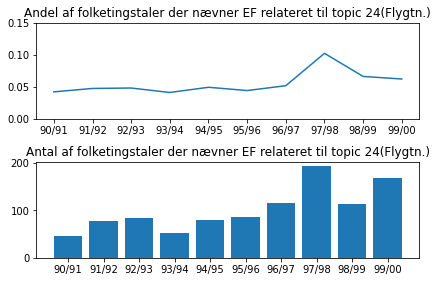

In [280]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 24(Flygtn.)")
ax1.plot(folketingsår, topics_flygtning_andel)
ax1.set_ylim([0, 0.15])
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 24(Flygtn.)")
ax2.bar(folketingsår, topics_flygtning_antal_taler_1990eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_24")

In [111]:
Flygtning_1997 = [i for i in topics_flygtning if Alle_taler_år[i] == "1997"]
len(Flygtning_1997)

193

In [117]:
sand_flygtning_1997 = [topics_flygtning_sand[topics_flygtning.index(i)] for i in Flygtning_1997]
sand_flygtning_1997_til_rensning = [sand for sand in sand_flygtning_1997]
sand_flygtning_1997_til_rensning.sort(reverse = True)

In [118]:
sand_flygtning_1997_til_rensning[0]

0.097881354

In [129]:
Alle_taler[Flygtning_1997[sand_flygtning_1997.index(sand_flygtning_1997_til_rensning[4])]]

' På baggrund af den omtalte artikel i Jyllands- Posten har jeg forstået spørgsmålet således, at det vedrører antallet af meddelte opholdstilladelser til flygtninge. Udlændingestyrelsen har oplyst, at man ikke er i besiddelse af oplysninger om det samlede antal meddelte opholdstilladelser til flygtninge i EU-landene. Udlændingestyrelsen har fra Eurostat, som er EU-Kommissionens statistikkontor, fået oplyst, at der ikke foreligger et samlet officielt tal for antallet af meddelte opholdstilladelser til flygtninge i Europa i 1996. Udlændingestyrelsen har imidlertid indhentet foreløbige oplysninger fra de enkelte EU- lande for så vidt angår meddelelse af opholdstilladelser i medfør af flygtningekonventionen. Ifølge disse oplysninger blev der i 1996 givet opholdstilladelse efter flygtningekonventionen til ca. 34.000 personer i EU-landene, heraf blev der givet 1.190 i Danmark. Spm. nr. S 169 Til indenrigsministeren (17/10 97) af:'

In [131]:
Flygtning_1997

[11556,
 11565,
 11566,
 11572,
 11581,
 11584,
 11585,
 11590,
 11595,
 11598,
 11657,
 11696,
 11699,
 11703,
 11706,
 11708,
 11720,
 11729,
 11730,
 11760,
 11789,
 11791,
 11792,
 11794,
 11798,
 11799,
 11800,
 11821,
 11823,
 11824,
 11827,
 11836,
 11841,
 11844,
 11847,
 11848,
 11851,
 11870,
 11931,
 11995,
 12002,
 12003,
 12028,
 12060,
 12181,
 12182,
 12183,
 12189,
 12191,
 12193,
 12235,
 12237,
 12240,
 12259,
 12271,
 12279,
 12294,
 12300,
 12308,
 12343,
 12344,
 12345,
 12346,
 12347,
 12351,
 12363,
 12402,
 12421,
 12434,
 12445,
 12472,
 12473,
 12475,
 12476,
 12477,
 12478,
 12479,
 12480,
 12482,
 12483,
 12484,
 12485,
 12487,
 12488,
 12489,
 12514,
 12539,
 12540,
 12541,
 12542,
 12543,
 12545,
 12548,
 12549,
 12550,
 12552,
 12554,
 12555,
 12558,
 12559,
 12560,
 12585,
 12590,
 12609,
 12629,
 12631,
 12639,
 12651,
 12653,
 12672,
 12677,
 12679,
 12681,
 12694,
 12695,
 12705,
 12711,
 12713,
 12771,
 12776,
 12777,
 12778,
 12780,
 12786,
 12792,


In [171]:
Alle_taler[11585]

" Jeg må gøre hr. Ove Fich opmærksom på, at det, jeg læste op af for lidt siden - hvis det ellers har hr. Ove Fichs interesse - faktisk var Amsterdamtraktaten og ikke Schengenaftalen, og jeg spurgte hr. Ove Fich, om det er sådan, at regeringen - når den nu vil til at indføre eksamen for flygtninge, for at de kan opnå permanent opholdstilladelse - har ladet sig inspirere af denne nye Traktat, som jo lægger op til, at en stor gruppe af flygtninge kun skal have midlertidig beskyttelse, så vi dermed, som fru Anne Baastrup også var inde på, krænker FN's flygtningekonvention. Jeg kunne også spørge hr. Ove Fich: Hvad siger hr. Ove Fich til, at der i Amsterdamtraktaten er en regel om, at borgere fra ét EU-land, f.eks. Spanien, ikke længere har ret til at flygte til Danmark? Det er også i strid med FN's flygtningekonvention, som vi har underskrevet. Jeg betvivler ikke, at hr. Ove Fich som privatperson har de helt rigtige holdninger til flygtninge, men jeg spørger hr. Ove Fich, om han ikke anser

In [169]:
partier_1997_flytninge = [Alle_taler_taler[i] for i in Flygtning_1997]

In [170]:
partier_1997_flytninge

['(V)',
 '(SF)',
 '(RV)',
 '(DF)',
 '(EL)',
 '(S)',
 '(EL)',
 '(EL)',
 '(V)',
 '(RV)',
 '(SF)',
 'Regeringen',
 '(V)',
 '(FP)',
 '(V)',
 '(FP)',
 '(S)',
 '(V)',
 '(KF)',
 '(S)',
 'næstformanden',
 '(RV)',
 '(EL)',
 '(FP)',
 '(V)',
 'Regeringen',
 'Regeringen',
 'Formanden',
 '(KF)',
 '(RV)',
 '(SF)',
 '(EL)',
 'Regeringen',
 '(DF)',
 '(V)',
 '(V)',
 'Formanden',
 '(KF)',
 '(EL)',
 '(CD)',
 '(EL)',
 '(EL)',
 'Regeringen',
 '(KF)',
 '(RV)',
 '(RV)',
 '(CD)',
 '(RV)',
 '(RV)',
 '(V)',
 'Regeringen',
 '(FP)',
 '(V)',
 'Regeringen',
 '(V)',
 '(DF)',
 '(EL)',
 'Regeringen',
 '(V)',
 '(KF)',
 '(SF)',
 '(SF)',
 '(SF)',
 '(SF)',
 '(FP)',
 '(DF)',
 'Regeringen',
 '(RV)',
 '(DF)',
 '(SF)',
 'Regeringen',
 '(S)',
 '(EL)',
 '(V)',
 '(SF)',
 '(V)',
 '(EL)',
 '(EL)',
 '(SF)',
 '(FP)',
 '(EL)',
 '(CD)',
 'Regeringen',
 '(V)',
 '(FP)',
 '(EL)',
 '(S)',
 '(EL)',
 '(V)',
 '(V)',
 '(KF)',
 '(SF)',
 '(RV)',
 '(EL)',
 '(CD)',
 '(DF)',
 '(FP)',
 'Formanden',
 '(KF)',
 '(SF)',
 '(KF)',
 'Regeringen',
 '(S)',


### Topic 2 om Justits

In [274]:
topics_justits = []
topics_justits_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 2:
            topics_justits.append(index)
            topics_justits_sand.append(sand)
len(topics_justits)

3864

In [275]:
topics_justits_år = [Alle_taler_år[i] for i in topics_justits]
topics_justits_antal_taler_1990eren = []

for år in år_1990erne:
    topics_justits_antal_taler_1990eren.append(topics_justits_år.count(år))
topics_justits_andel = [topics_justits_antal_taler_1990eren[i]/antal_taler_år[i] for i in range(10)]

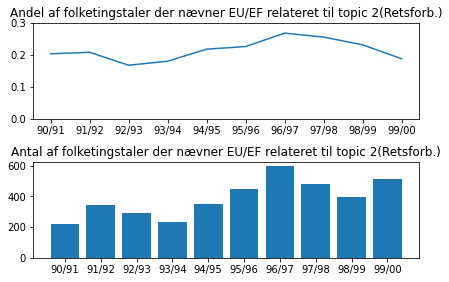

In [277]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EU/EF relateret til topic 2(Retsforb.)")
ax1.plot(folketingsår, topics_justits_andel)
ax1.set_ylim([0, 0.3])
ax2.set_title("Antal af folketingstaler der nævner EU/EF relateret til topic 2(Retsforb.)")
ax2.bar(folketingsår, topics_justits_antal_taler_1990eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_2")

Rets og politi fra 1994 og frem:


In [187]:
justits_efter_1994 = [i for i in topics_justits if int(Alle_taler_år[i]) >= 1994]

In [188]:
justits_efter_1994_taler = [Alle_taler_taler[i] for i in justits_efter_1994]

In [190]:
for i in list(set(justits_efter_1994_taler)):
    print(f"{i}: {justits_efter_1994_taler.count(i)}")

(S): 185
(EL): 491
(DF): 279
næstformanden: 26
(RV): 102
(FP): 245
Formanden: 39
(UP): 10
(V): 272
Regeringen: 655
(SF): 190
(CD): 62
(KF): 227


### Topic 28 - børnepolitik:

In [191]:
topics_børnepolitik = []
topics_børnepolitik_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 28:
            topics_børnepolitik.append(index)
            topics_børnepolitik_sand.append(sand)
len(topics_børnepolitik)

2449

In [192]:
topics_børnepolitik_år = [Alle_taler_år[i] for i in topics_børnepolitik]
topics_børnepolitik_antal_taler_1990eren = []

for år in år_1990erne:
    topics_børnepolitik_antal_taler_1990eren.append(topics_børnepolitik_år.count(år))
topics_børnepolitik_andel = [topics_børnepolitik_antal_taler_1990eren[i]/antal_taler_år[i] for i in range(10)]

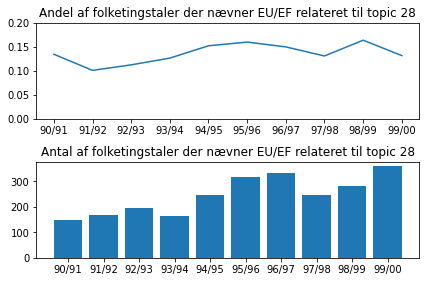

In [236]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EU/EF relateret til topic 28")
ax1.plot(folketingsår, topics_børnepolitik_andel)
ax1.set_ylim([0, 0.2])
ax2.set_title("Antal af folketingstaler der nævner EU/EF relateret til topic 28")
ax2.bar(folketingsår, topics_børnepolitik_antal_taler_1990eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_28")

In [217]:
børnepolitik_sand = [sand for sand in topics_børnepolitik_sand]
børnepolitik_sand.sort(reverse = True)

In [246]:
n = 9
print(Alle_taler_år[topics_børnepolitik[topics_børnepolitik_sand.index(børnepolitik_sand[n])]])
print(Alle_taler_parti[topics_børnepolitik[topics_børnepolitik_sand.index(børnepolitik_sand[n])]])
Alle_taler[topics_børnepolitik[topics_børnepolitik_sand.index(børnepolitik_sand[n])]]

1999
Søren Kolstrup (EL):


" Enhedslisten er enig med Frihed 2000 i deres beskrivelse af modsætningen mellem forskellige redegørelser om netværkssamfundet og den faktiske virkelighed på mange folkeskoler; ikke mindst kan vi se en fremtidig opdeling af befolkningen i dem, der kan IT, og dem, der ikke kan IT, hvis ikke vi som samfund tager et ansvar for, at alle får mulighed for at lære at bruge IT. Hvis vi vil en folkeskole, der lever op til de krav, der stilles til den, kræver det jo flere ressourcer, ikke kun, men også til IT. Når så det er sagt, så mener vi i Enhedslisten ikke umiddelbart, at Frihed 2000's forslag om obligatorisk computerundervisning som fag er et egnet instrument, der kan fremme en bred investering i den danske folkeskole. Vi finder, det er vigtigt, at alle har adgang til Internettet generelt, at alle elever har adgang til Internettet i de enkelte fag, i de enkelte discipliner og i de enkelte projekter, de er med i, og at IT bliver en naturlig del af undervisningen. Løsningen er selvfølgelig,

### Topic 21 Transport:

In [194]:
topics_transport = []
topics_transport_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 21:
            topics_transport.append(index)
            topics_transport_sand.append(sand)
len(topics_transport)

887

In [195]:
topics_transport_år = [Alle_taler_år[i] for i in topics_transport]
topics_transport_antal_taler_1990eren = []

for år in år_1990erne:
    topics_transport_antal_taler_1990eren.append(topics_transport_år.count(år))
topics_transport_andel = [topics_transport_antal_taler_1990eren[i]/antal_taler_år[i] for i in range(10)]

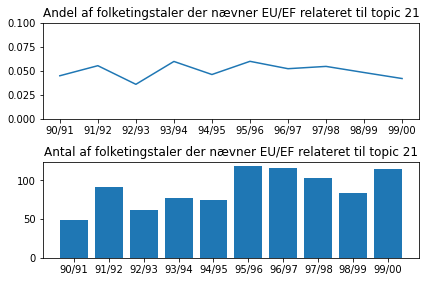

In [197]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EU/EF relateret til topic 21")
ax1.plot(folketingsår, topics_transport_andel)
ax1.set_ylim([0, 0.1])
ax2.set_title("Antal af folketingstaler der nævner EU/EF relateret til topic 21")
ax2.bar(folketingsår, topics_transport_antal_taler_1990eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_21")

In [198]:
Alle_taler[topics_transport[topics_transport_sand.index(max(topics_transport_sand))]]

' Hr. Erling Christensen skal nu ikke være så sikker på, at vi får så hurtig en sagsbehandling i udvalget, for jeg synes, at der er en række problemer i dette, og at der er en række ting, som den socialdemokratiske ordfører ikke har taget stilling til. Hvis vi skal starte fra en ende af, bliver det således, at der stadig væk bliver en vægtgrænse på 60 kg. Hvis man fremstiller en knallert, der kan køre 30 km/t, men som har et sikkerhedsudstyr, der er bedre end de nuværende knallerters, og knallerten når op over 60 kg-grænsen, skal knallerten indregistreres, og man skal have kørekort til motorcykel, for at man må køre på den, plus at knallerten skal køre på vejen, altså ud mellem bilerne. En knallert, der kører 30 km/t, ud mellem bilerne! Jeg vil godt høre, hvori hr. Erling Christensen mener at det trafiksikkerhedsmæssige ligger i det? Hr. Erling Christensen var selv inde på EF- kørekortdirektivet, og det foreskriver, at definitionen af en motorcykel er, at det er et køretøj, der konstru

In [199]:
transport_sand = [sand for sand in topics_transport_sand]
transport_sand.sort(reverse = True)

In [216]:
n = 7
print(Alle_taler_år[topics_transport[topics_transport_sand.index(transport_sand[n])]])
print(Alle_taler_parti[topics_transport[topics_transport_sand.index(transport_sand[n])]])
Alle_taler[topics_transport[topics_transport_sand.index(transport_sand[n])]]

1998
Økonomiministeren (Marianne Jelved):


' De danske nettobetalinger til EU skønnes at blive 4 mia. kr. i 1999 og mia. kr. i år 2000 opgjort efter principperne i betalingsbalancestati- stikken. Dette er baseret på den seneste statistik for betalingsbalancen og Økonomisk Oversigt, december 1998. Stigningen i nettobidraget fra 1998 skyldes både større betalinger til EU og mindre betalinger fra EU blandt andet i form af mindre hektarstøtte. Det skal bemærkes, at opgørelsen af nettobetalingerne afhænger af den anvendte metode. Kommissionen foretager opgørelser, hvor de medtager blandt andet fordelingen af EUs administrationsudgifter på de enkelte EU-lande. Her bliver det danske nettobidrag noget mindre, jf. besvarelsen af spørgsmål S 1609. En tommelfingerregel siger, at EUs opgørelse er ca. 1 mia. kr. mere positiv end Danmarks Statistiks opgørelse af betalingerne til EU. Spm. nr. S 1769 Til fødevareministeren (15/4 99) af:'

### Plot af transport og uddannelse:

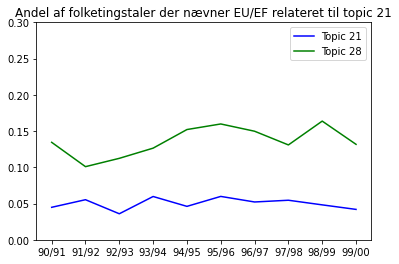

In [228]:
fig, ax = plt.subplots()
ax.set_title("Andel af folketingstaler der nævner EU/EF relateret til topic 21")
ax.plot(folketingsår, topics_transport_andel, color = "b", label = "Topic 21")
ax.plot(folketingsår, topics_børnepolitik_andel, color = "g", label = "Topic 28")
ax.legend()
ax.set_ylim([0, 0.3])
fig.savefig("plots/1990_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_21_og_28")

# Maastricht og Edinburgh:

In [129]:
EU_ord_maastriicht = ["maastricht", "edinburgh"]

In [130]:
eu_taler_90erne_maastricht = {}
for år in Folketingsår_opdelt_per_taler_90erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_90erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_90erne[år][0][index]
        for ord_ in EU_ord_maastriicht:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_parti_år.append(Folketingsår_opdelt_per_taler_90erne[år][1][index])
                eu_taler_år.append(Folketingsår_opdelt_per_taler_90erne[år][2][index])
                break
    eu_taler_90erne_maastricht[år] = []
    eu_taler_90erne_maastricht[år].append(eu_tale_år)
    eu_taler_90erne_maastricht[år].append(eu_parti_år)
    eu_taler_90erne_maastricht[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [131]:
len(eu_taler_90erne_maastricht["1994"][0])

190

In [132]:
for år in eu_taler_90erne_maastricht:
    print(f"{år}: {len(eu_taler_90erne_maastricht[år][0])}")

1990: 0
1991: 146
1992: 382
1993: 138
1994: 190
1995: 147
1996: 232
1997: 155
1998: 56
1999: 118


In [133]:
tekster_klar_maastricht = []
for år in eu_taler_90erne_maastricht:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_90erne_maastricht[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar_maastricht.append(tokens_uden_tegn)
    end = time()
    print(end-start)

8.821487426757812e-06
19.32711100578308
42.672616958618164
24.211318969726562
22.661864757537842
16.3078830242157
27.395601272583008
19.11690092086792
9.913466930389404
14.296633005142212


In [134]:
Alle_taler_maastricht = []
Alle_taler_år_maastricht = []
Alle_taler_parti_maastricht = []
Alle_taler_taler_maastricht = []
for år in eu_taler_90erne_maastricht:
    for index in range(len(eu_taler_90erne_maastricht[år][0])):
        Alle_taler_maastricht.append(eu_taler_90erne_maastricht[år][0][index])
        Alle_taler_parti_maastricht.append(eu_taler_90erne_maastricht[år][1][index])
        Alle_taler_taler_maastricht.append(eu_taler_90erne_maastricht[år][2][index])
        Alle_taler_år_maastricht.append(år)

In [135]:
Alle_taler_maastricht[randint(0, len(Alle_taler_maastricht))]

" Når man læser teksten til forespørgslen, og måske især når man hører ordføreren for Enhedslisten, ledes man meget let til den konklusion, at EU-beslutninger systematisk sænker dansk standard på miljøområdet, arbejdsmiljøområdet, sundhedsområdet og forbrugerområdet. Det er en myte, der desværre trives alt for vel. Sandheden er, at EU-reguleringen i langt de fleste tilfælde har været på dansk niveau eller over. Det er dokumenteret i en række bilag i Europaudvalget, og det undrer mig, at især hr. Keld Albrechtsen kan hævde det modsatte, når han selv er medlem af Europaudvalget. Hvis man kigger på disse bilag, viser data følgende: På miljøområdet er der i perioden 1992-93 kommet 29 direktiver eller forordninger, som forbedrer de danske regler, og 3, der gør dem dårligere. Der er f.eks. kommet bedre regler for grænseoverskridende transport af farligt affald inden for EU, for luftforurening fra store fyringsanlæg, Torsdag den 23. marts 1995 (F 24) 4237 for en tidlig udfasning af HCFC og me

In [136]:
processed_data_maastricht = []
for tekst in tekster_klar_maastricht:
    str_tekst = [str(token) for token in tekst]
    processed_data_maastricht.append(str_tekst)

In [137]:
bigram_maastricht = gensim.models.Phrases(processed_data_maastricht, min_count=5, threshold=100)

trigram_maastricht = gensim.models.Phrases(bigram[processed_data_maastricht], threshold=100)

bigram_mod_maastricht = gensim.models.phrases.Phraser(bigram_maastricht)

trigram_mod_maastricht = gensim.models.phrases.Phraser(trigram_maastricht)

In [138]:
def remove_stopwords_maastricht(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams_maastricht(texts):
    return [bigram_mod_maastricht[doc] for doc in texts]
def create_trigrams_maastricht(texts):
    [trigram_mod[bigram_mod_maastricht[doc]] for doc in texts]
def lemmatize_maastricht(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [139]:
data_wo_stopwords_maastricht = remove_stopwords(processed_data_maastricht)

data_bigrams_maastricht = create_bigrams_maastricht(data_wo_stopwords_maastricht)

data_lemmatized_maastricht = lemmatize_maastricht(data_bigrams_maastricht, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

stopwords_removed_2_maastricht = remove_stopwords_maastricht(data_lemmatized_maastricht) #Jeg prøver at sortere stopord fra igen

data_lemmatized_maastricht = stopwords_removed_2_maastricht

65.07245016098022


In [140]:
texts_maastricht = [text for text in data_lemmatized_maastricht]

In [141]:
shuffle(texts_maastricht)

In [142]:
gensim_dictionary_maastricht = corpora.Dictionary(texts_maastricht)

gensim_corpus_maastricht = [gensim_dictionary_maastricht.doc2bow(text) for text in texts_maastricht]

In [143]:
gensim_dictionary_maastricht.save("Speciale_scripts/Dictionaries/Maastricht/10_10_22_02")

### Topic model Maastricht 

In [144]:
def compute_coherence_values_maastricht(k):
    lda_model_maastricht = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_maastricht,
                                           id2word=gensim_dictionary_maastricht,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda_maastricht = CoherenceModel(model=lda_model_maastricht, texts=data_lemmatized_maastricht, dictionary=gensim_dictionary_maastricht, coherence='c_v')
    return coherence_model_lda_maastricht.get_coherence()

In [145]:
min_topics = 5
max_topics = 25
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results_maastricht = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values_maastricht(k=k)
    # Save the model results
    model_results_maastricht['Topics'].append(k)
    model_results_maastricht['Coherence'].append(cv)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


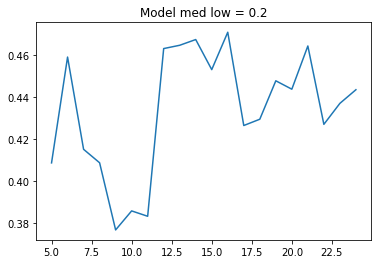

In [146]:
fig, ax = plt.subplots()
ax.plot(model_results_maastricht["Topics"], model_results_maastricht['Coherence'])
ax.set_title("Model med low = 0.2")
fig.savefig("Speciale_scripts/plots/maastricht/Coherence_score_10_10_22_02")

In [147]:
coherence_best_maastricht = [coherence for coherence in model_results_maastricht['Coherence']]
coherence_best_maastricht.sort(reverse = True)

In [148]:
for top_coherence in coherence_best_maastricht[0:3]:
    number_topics_maastricht = model_results_maastricht["Topics"][model_results_maastricht['Coherence'].index(top_coherence)]
    print(number_topics_maastricht)
    lda_model_maastricht = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus_maastricht, id2word=gensim_dictionary_maastricht, num_topics=number_topics_maastricht, random_state=100, 
        update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    lda_model_maastricht.save(f"Speciale_scripts/Modeller/maastricht/10_10_2022_02/Model_{number_topics_maastricht}_topics")

16
14
13


In [159]:
lda_model_maastricht = gensim.models.ldamodel.LdaModel.load("Speciale_scripts/Modeller/maastricht/10_10_2022_02/Model_13_topics")
pprint(lda_model_maastricht.print_topics(33))

[(0,
  '0.082*"grønland" + 0.037*"færøerne" + 0.008*"ecu" + 0.006*"procent" + '
  '0.002*"folkebibliotek" + 0.001*"ef-samar-" + 0.000*"grønlands" + '
  '0.000*"rigsfællesskab" + 0.000*"landsstyre" + 0.000*"åbningstale_del"'),
 (1,
  '0.032*"forslag" + 0.025*"lov" + 0.022*"ændring" + 0.015*"spørgsmål" + '
  '0.013*"lovforslag" + 0.013*"minister" + 0.012*"regel" + 0.011*"danmark" + '
  '0.010*"regering" + 0.009*"sag"'),
 (2,
  '0.034*"land" + 0.025*"samarbejde" + 0.015*"eu" + 0.012*"område" + '
  '0.012*"danmark" + 0.010*"europa" + 0.009*"regering" + 0.008*"medlemsland" + '
  '0.008*"udvikling" + 0.007*"mulighed"'),
 (3,
  '0.055*"dato" + 0.036*"pris_kr" + 0.035*"destination" + 0.032*"ledsager" + '
  '0.021*"kulturminister" + 0.020*"besøg" + 0.017*"formål" + 0.013*"skole" + '
  '0.011*"formål_åbning" + 0.010*"erik_jacobsen"'),
 (4,
  '0.017*"gå" + 0.016*"hr." + 0.015*"danmark" + 0.013*"stå" + 0.013*"altså" + '
  '0.010*"regering" + 0.010*"folkeafstemning" + 0.010*"befolkning" + '
  '0.01

In [ ]:
#os.system("sudo shutdown /s /t 1")